In [1]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
import matplotlib
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_names
import copy

In [2]:
print('Getting embeddings')
m = 2
b = 49
n = 10000
d = 2
data, rotator, ts, ys = get_swiss_roll_data(n = n, theta = np.pi / 4,xvar = 0., rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  
ltsa = LTSA(n_components=m,eigen_solver='arpack',geom=geom)
embed_ltsa = ltsa.fit_transform(data)
isomap_embedding = Isomap(n_components=m,eigen_solver='arpack',geom=geom)
embed_isomap = isomap_embedding.fit_transform(data)
spectral_embedding = SpectralEmbedding(n_components=m,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)
swiss_internal = np.asarray([ts ,ys]).transpose()

Getting embeddings


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  ins

In [3]:
nreps = 1
nsel = 100 
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p',
                                   replicates[r].dg_x_normalized, 
                                   replicates[r].tangent_bases_M)

In [4]:
replicates_internal = copy.deepcopy(replicates)
replicates_ltsa = copy.deepcopy(replicates)
replicates_isomap = copy.deepcopy(replicates)
replicates_spectral = copy.deepcopy(replicates)
for r in range(nreps):
    replicates_spectral[r].tangent_bases_phi = get_rm_tangent_sel(embed_spectral, geom, replicates[r].selected_points, d)
    replicates_spectral[r].dphi_M = get_grads_pullback(data, 
                                                       embed_spectral,
                                                       geom, 
                                                       replicates[r].tangent_bases_M, 
                                                       replicates_spectral[r].tangent_bases_phi, 
                                                       replicates[r].selected_points)
    replicates_spectral[r].dphi_M_normalized = normalize_L212(replicates_spectral[r].dphi_M)
    replicates_spectral[r].results = get_sr_lambda_parallel(replicates_spectral[r].dphi_M_normalized, replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)
    replicates_spectral[r].get_ordered_axes()
    
    

    
    replicates_isomap[r].tangent_bases_phi = get_rm_tangent_sel(embed_isomap, geom, replicates[r].selected_points, d)
    replicates_isomap[r].dphi_M = get_grads_pullback(data,  embed_isomap, geom,
                                                     replicates[r].tangent_bases_M, 
                                                     replicates_isomap[r].tangent_bases_phi, 
                                                     replicates[r].selected_points)
    replicates_isomap[r].dphi_M_normalized = normalize_L212(replicates_isomap[r].dphi_M)
    replicates_isomap[r].results = get_sr_lambda_parallel(replicates_isomap[r].dphi_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)
    replicates_isomap[r].get_ordered_axes()
    
    replicates_ltsa[r].tangent_bases_phi = get_rm_tangent_sel(embed_ltsa, geom, replicates[r].selected_points, d)
    replicates_ltsa[r].dphi_M = get_grads_pullback(data, 
                                                       embed_ltsa, 
                                                       geom, 
                                                       replicates[r].tangent_bases_M,
                                                       replicates_ltsa[r].tangent_bases_phi, 
                                                       replicates[r].selected_points)
    replicates_ltsa[r].dphi_M_normalized = normalize_L212(replicates_ltsa[r].dphi_M)
    replicates_ltsa[r].results = get_sr_lambda_parallel(replicates_ltsa[r].dphi_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)
    replicates_ltsa[r].get_ordered_axes()
    
    replicates_internal[r].tangent_bases_phi = get_rm_tangent_sel(swiss_internal, geom, replicates[r].selected_points, d)
    replicates_internal[r].dphi_M = get_grads_pullback(data,  swiss_internal, geom,
                                                       replicates[r].tangent_bases_M,
                                                       replicates_internal[r].tangent_bases_phi, 
                                                       replicates[r].selected_points)
    replicates_internal[r].dphi_M_normalized = normalize_L212(replicates_internal[r].dphi_M)
    replicates_internal[r].results = get_sr_lambda_parallel(replicates_internal[r].dphi_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)
    replicates_internal[r].get_ordered_axes()

initializing lambda search
converged 10.000677015116784
0 5.000338507558392 probe
converged 5.000338507558392
Selected functions [0 1]
initializing lambda search
converged 9.99977842790648
0 4.99988921395324 probe
converged 4.99988921395324
Selected functions [0 1]
initializing lambda search
converged 9.99983647487156
0 4.99991823743578 probe
converged 4.99991823743578
Selected functions [0 1]
initializing lambda search
converged 9.999791375307494
0 4.999895687653747 probe
converged 4.999895687653747
Selected functions [0 1]


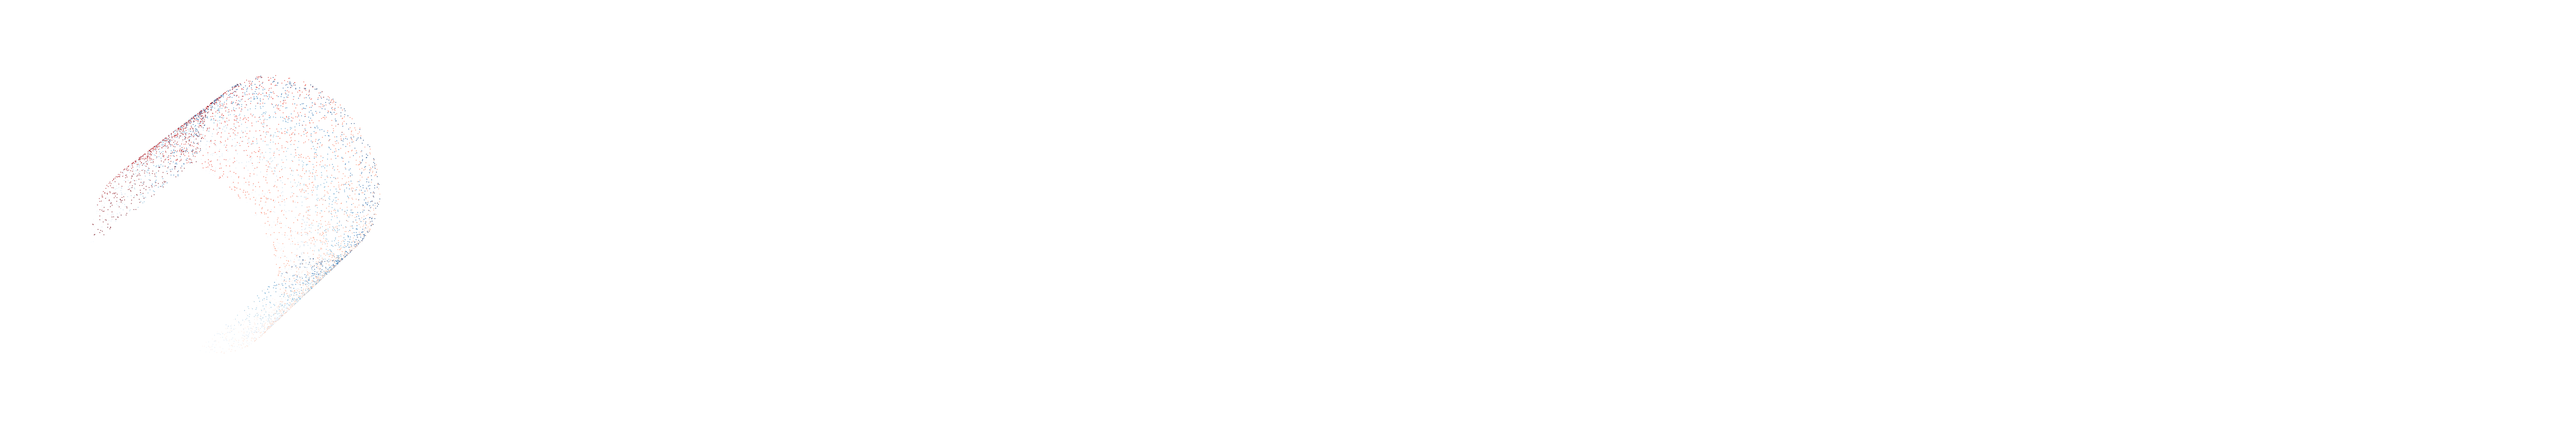

In [5]:
%matplotlib inline
unr = data @ rotator.transpose()
data_plot = unr[:,:3]

fig, axes_all = plt.subplots(figsize=(15,15))
axes_all.set_axis_off()
alpha = .05
ax = fig.add_subplot(1,1,1, projection='3d')
x = data_plot[:, 0]
y = data_plot[:, 1]
z = data_plot[:, 2]
s = 1
alpha = 1.
inds1  = list(range(2500))
inds2 = np.asarray(list(range(2500))) + 2500
ax.scatter(x[inds1], y[inds1], z[inds1], s=s, alpha=alpha, marker='.', c = ts[inds1], cmap = 'Reds')
ax.scatter(x[inds2], y[inds2], z[inds2], s=s, alpha=alpha, marker='.', c = ys[inds2], cmap = 'Blues')
ax.set_axis_off()
#plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/unrotated', bbox_inches = "tight")


Text(-0.08, 0.5, 'Internal Coordinates \n (ground truth)')

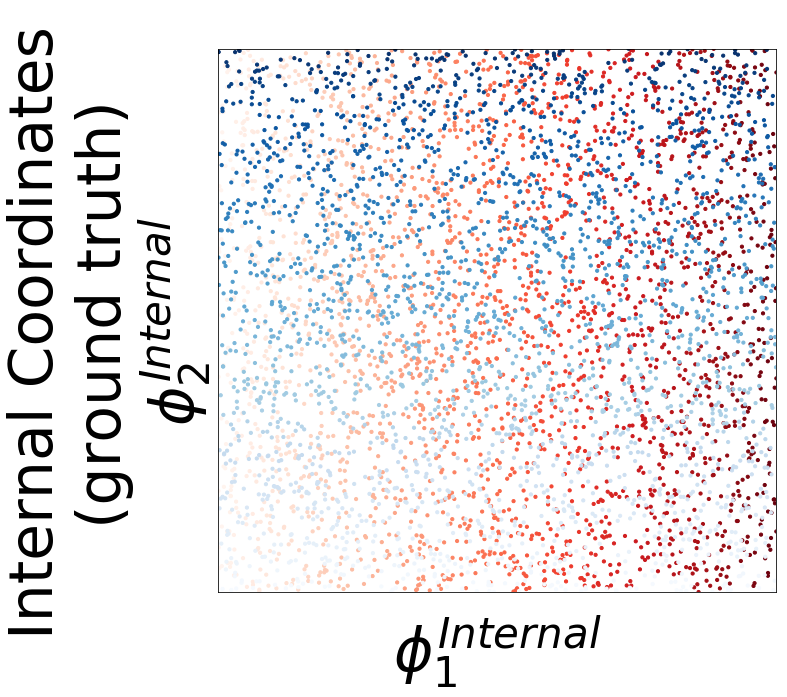

In [6]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )

axes_all.scatter(swiss_internal[inds1,0],swiss_internal[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(swiss_internal[inds2,0],swiss_internal[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(swiss_internal[:,0].min(), swiss_internal[:,0].max())
axes_all.set_ylim(swiss_internal[:,1].min(), swiss_internal[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
axes_all.set_xlabel(r'$\phi_1^{Internal}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{Internal}$', fontsize = 60)
fig.text(-0.08, 0.5, 'Internal Coordinates \n (ground truth)', ha='center', va='center', rotation='vertical', fontsize = 60)
#plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/sr_internal', bbox_inches = "tight")


Text(-0.04, 0.5, 'Diffusion Maps')

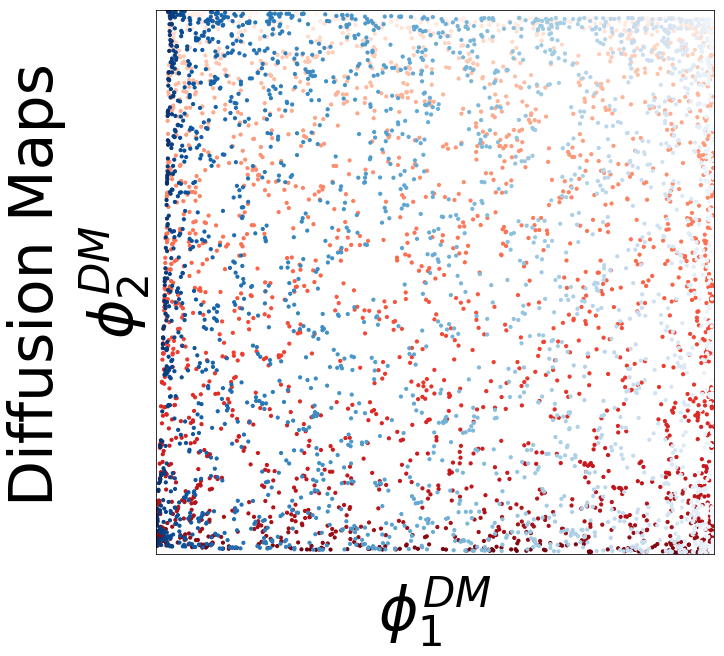

In [7]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embed_spectral[inds1,0],embed_spectral[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(embed_spectral[inds2,0],embed_spectral[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(embed_spectral[:,0].min(), embed_spectral[:,0].max())
axes_all.set_ylim(embed_spectral[:,1].min(), embed_spectral[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
axes_all.set_xlabel(r'$\phi_1^{DM}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{DM}$', fontsize = 60)
fig.text(-0.04, 0.5, 'Diffusion Maps', ha='center', va='center', rotation='vertical', fontsize = 60)
#plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/sr_spectral', bbox_inches = "tight")


Text(-0.04, 0.5, 'LTSA')

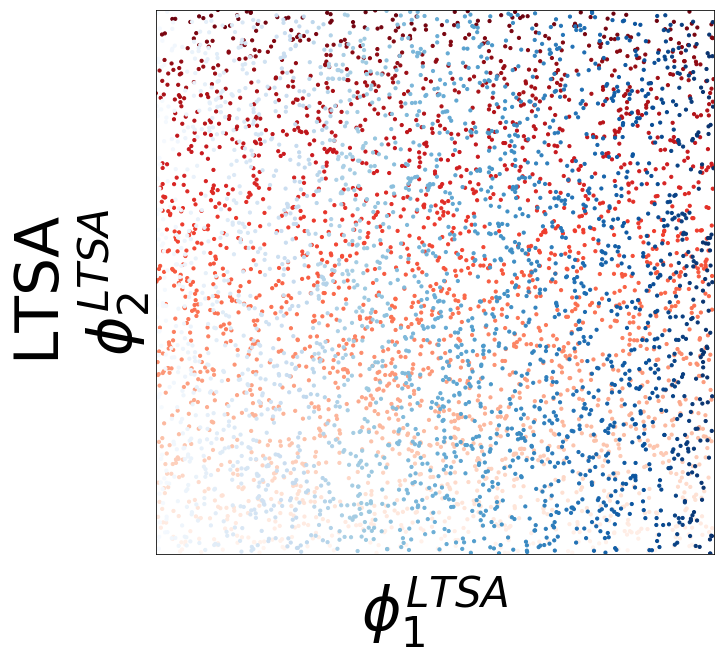

In [8]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
swiss_ltsa = embed_ltsa
axes_all.scatter(embed_ltsa[inds1,0],embed_ltsa[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(embed_ltsa[inds2,0],embed_ltsa[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(embed_ltsa[:,0].min(), embed_ltsa[:,0].max())
axes_all.set_ylim(embed_ltsa[:,1].min(), embed_ltsa[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
axes_all.set_xlabel(r'$\phi_1^{LTSA}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{LTSA}$', fontsize = 60)
fig.text(-0.04, 0.5, 'LTSA', ha='center', va='center', rotation='vertical', fontsize = 60)
#plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/sr_ltsa', bbox_inches = "tight")

Text(-0.04, 0.5, 'Isomap')

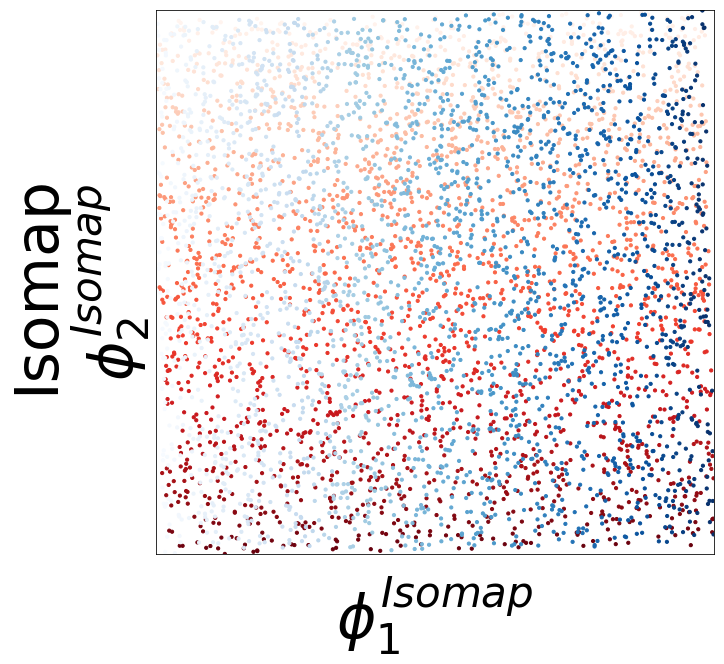

In [9]:
%matplotlib inline
fig, axes_all = plt.subplots(figsize=(10,10) )
swiss_isomap = embed_isomap
axes_all.scatter(embed_isomap[inds1,0],embed_isomap[inds1,1], s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
axes_all.scatter(embed_isomap[inds2,0],embed_isomap[inds2,1], s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
axes_all.set_xlim(embed_isomap[:,0].min(), embed_isomap[:,0].max())
axes_all.set_ylim(embed_isomap[:,1].min(), embed_isomap[:,1].max())
axes_all.set_xticks([])
axes_all.set_yticks([])
axes_all.set_xlabel(r'$\phi_1^{Isomap}$', fontsize = 60, labelpad=20)
axes_all.set_ylabel(r'$\phi_2^{Isomap}$', fontsize = 60)
fig.text(-0.04, 0.5, 'Isomap', ha='center', va='center', rotation='vertical', fontsize = 60)
#plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/sr_isomap', bbox_inches = "tight")

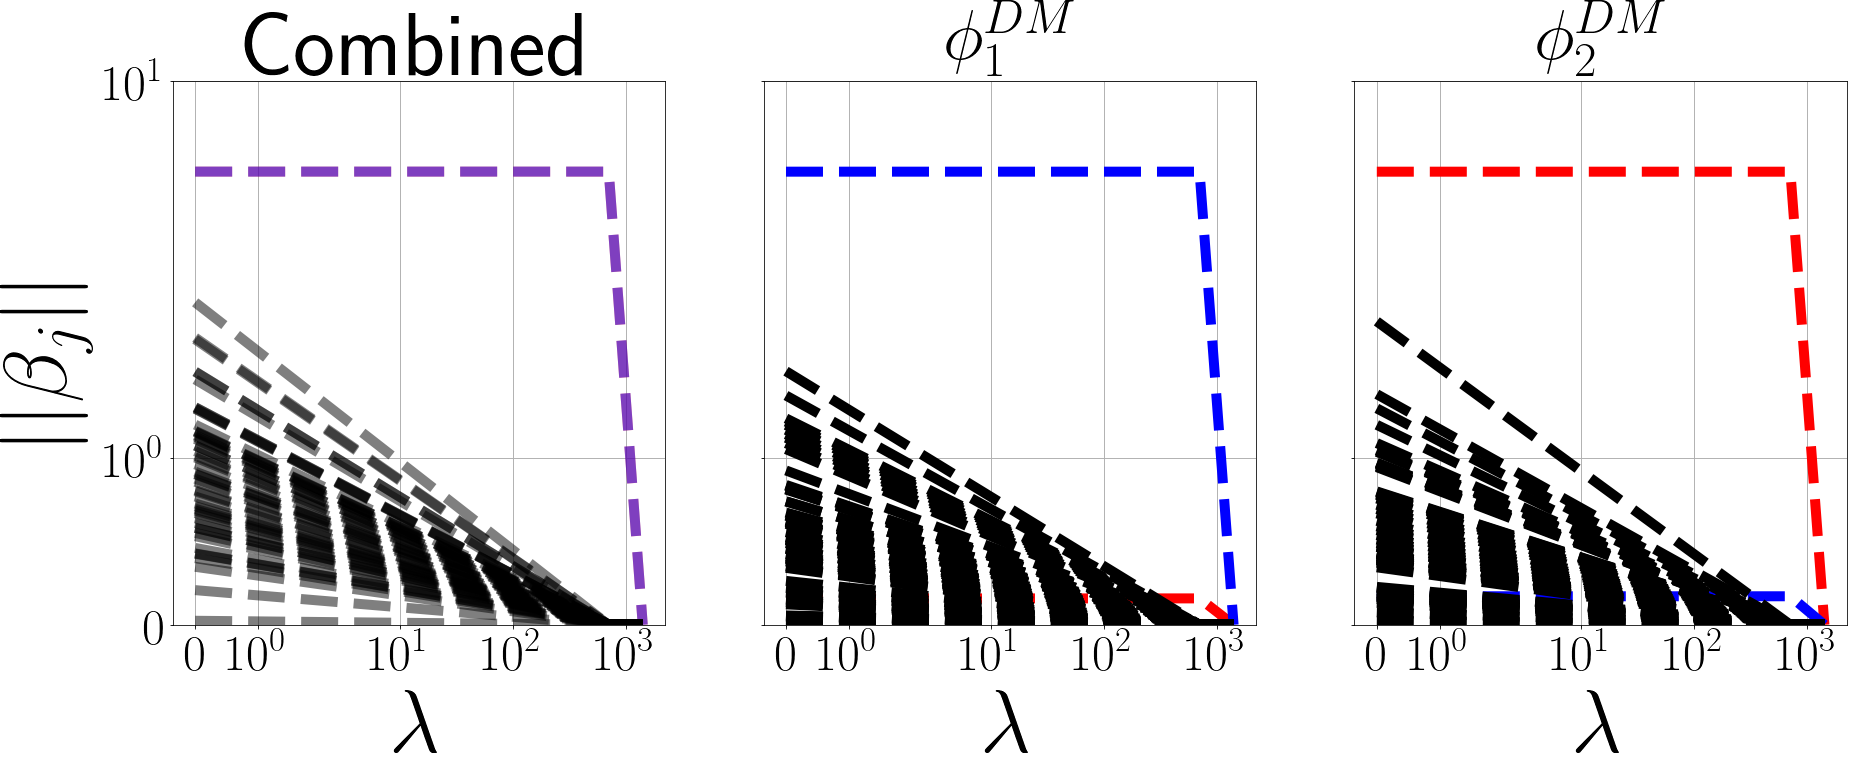

In [11]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
colors_all = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])
names = [r'$\phi_1^{DM}$', r'$\phi_2^{DM}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_spectral[0].cs_reorder, replicates_spectral[0].xaxis_reorder  * np.sqrt(m*n) , fig,colors_all, names)
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/spectral_flasso', bbox_inches = "tight")

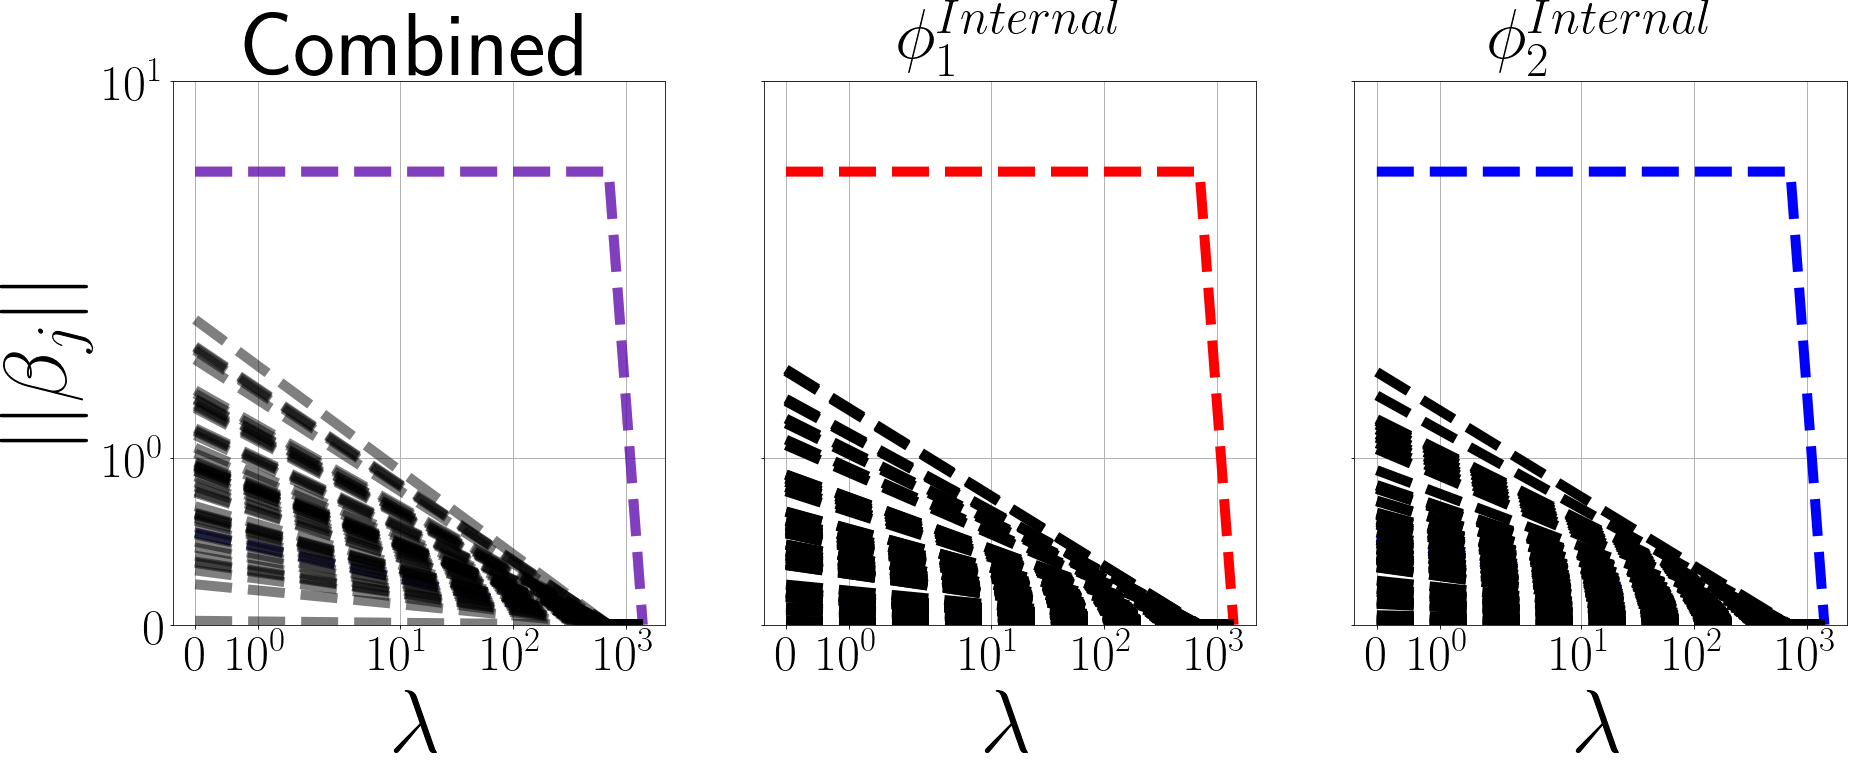

In [12]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
colors_all = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',49)])
names = [r'$\phi_1^{Internal}$', r'$\phi_2^{Internal}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_internal[0].cs_reorder, replicates_internal[0].xaxis_reorder  * np.sqrt(m*n) , fig,colors_all, names)
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/internal_flasso', bbox_inches = "tight")

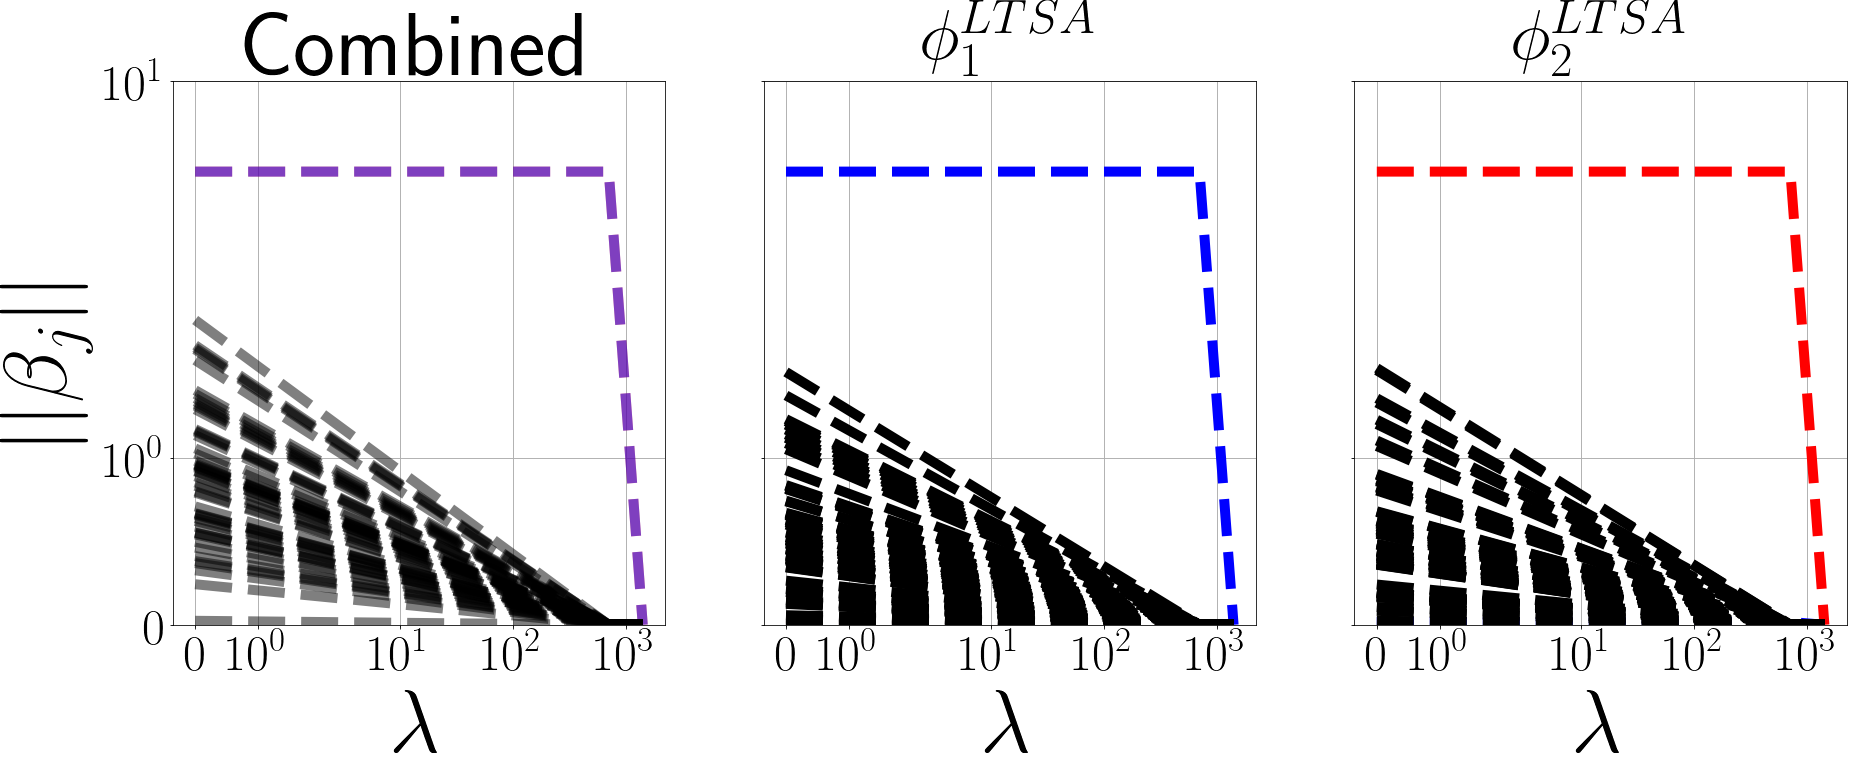

In [13]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
colors_all = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])
names = [r'$\phi_1^{LTSA}$', r'$\phi_2^{LTSA}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates_ltsa[0].cs_reorder, 
                                                 replicates_ltsa[0].xaxis_reorder  * np.sqrt(m*n) ,
                                                 fig,colors_all, names)
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/ltsa_flasso', bbox_inches = "tight")

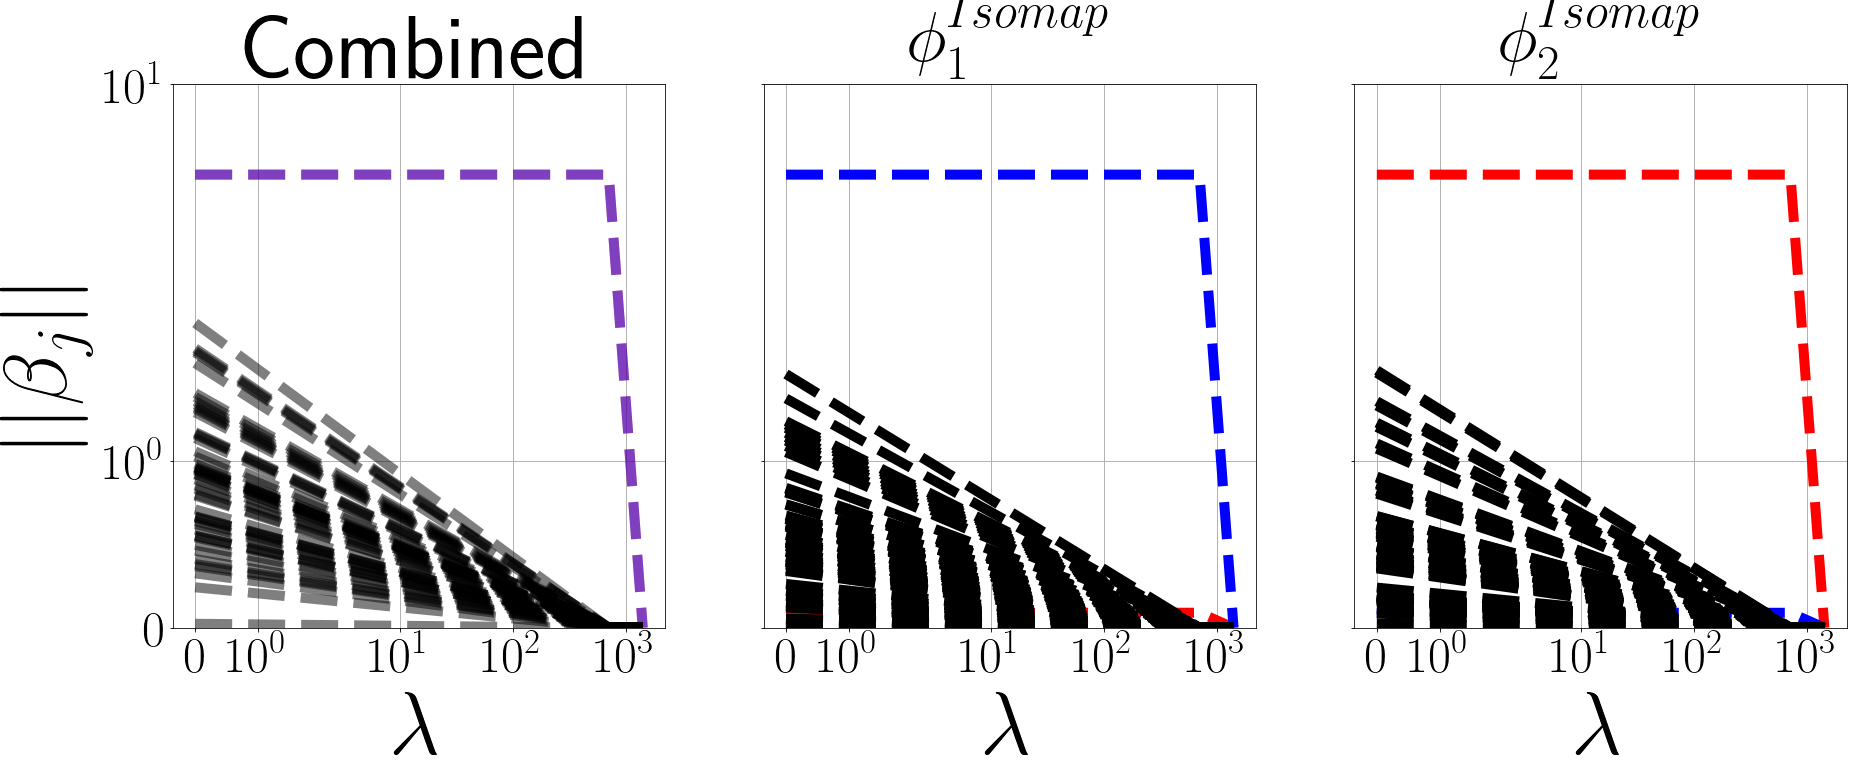

In [14]:
%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10))
colors_all = np.hstack([np.repeat('red',1), np.repeat('blue',1),np.repeat('black',49)])
names = [r'$\phi_1^{Isomap}$', r'$\phi_2^{Isomap}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, 
                                                 replicates_isomap[0].cs_reorder, 
                                                 replicates_isomap[0].xaxis_reorder  * np.sqrt(m*n) ,
                                                 fig,
                                                 colors_all, names)
plt.savefig('/Users/samsonkoelle/mani-samk-gradients/Figures/jmlr_minorrevision/swissroll/isomap_flasso', bbox_inches = "tight")